In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


# Data processing

In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define directories
DIR_MAIN = 'Final/Working_combined_fp/'
DIR_ANEMIA = DIR_MAIN + 'A/'
DIR_NON_ANEMIA = DIR_MAIN + 'NA/'

# Initialize lists for files and labels
files = []
labels = []

# Load images and labels from Anemia folder
for filename in os.listdir(DIR_ANEMIA):
    files.append(DIR_ANEMIA + filename)
    labels.append('Anemic')

# Load images and labels from Non-anemia folder
for filename in os.listdir(DIR_NON_ANEMIA):
    files.append(DIR_NON_ANEMIA + filename)
    labels.append('Non-anemic')

# Split the dataset into train, validation, and test sets
files_train, files_temp, labels_train, labels_temp = train_test_split(files, labels, test_size=0.4, random_state=42, stratify=labels)
files_val, files_test, labels_val, labels_test = train_test_split(files_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)

# Encode labels
encoder_labels = LabelEncoder()
labels_train_encoded = encoder_labels.fit_transform(labels_train)
labels_val_encoded = encoder_labels.transform(labels_val)
labels_test_encoded = encoder_labels.transform(labels_test)

# Print some sample files and labels
print("The first five files from the list of train images:", files_train[:5])
print("\nThe first five labels from the list of train labels:", labels_train[:5])
print("\nThe first five files from the list of validation images:", files_val[:5])
print("\nThe first five labels from the list of validation labels:", labels_val[:5])
print("\nThe first five files from the list of test images:", files_test[:5])


The first five files from the list of train images: ['Final/Working_combined_fp/A/20200224_143301_forniceal_palpebral.jpg', 'Final/Working_combined_fp/A/20200213_120556_forniceal_palpebral.jpg', 'Final/Working_combined_fp/A/20200211_150240_forniceal_palpebral.jpg', 'Final/Working_combined_fp/A/20200219_201501_forniceal_palpebral.jpg', 'Final/Working_combined_fp/NA/T_60_20190612_091032_forniceal_palpebral.jpg']

The first five labels from the list of train labels: ['Anemic', 'Anemic', 'Anemic', 'Anemic', 'Non-anemic']

The first five files from the list of validation images: ['Final/Working_combined_fp/NA/T_8_20190607_075130_forniceal_palpebral.jpg', 'Final/Working_combined_fp/NA/T_89_20190614_082828_forniceal_palpebral.jpg', 'Final/Working_combined_fp/NA/016_forniceal_palpebral.jpg', 'Final/Working_combined_fp/A/027_forniceal_palpebral.jpg', 'Final/Working_combined_fp/A/20200213_150536_forniceal_palpebral.jpg']

The first five labels from the list of validation labels: ['Non-anemic', '

# Dataset

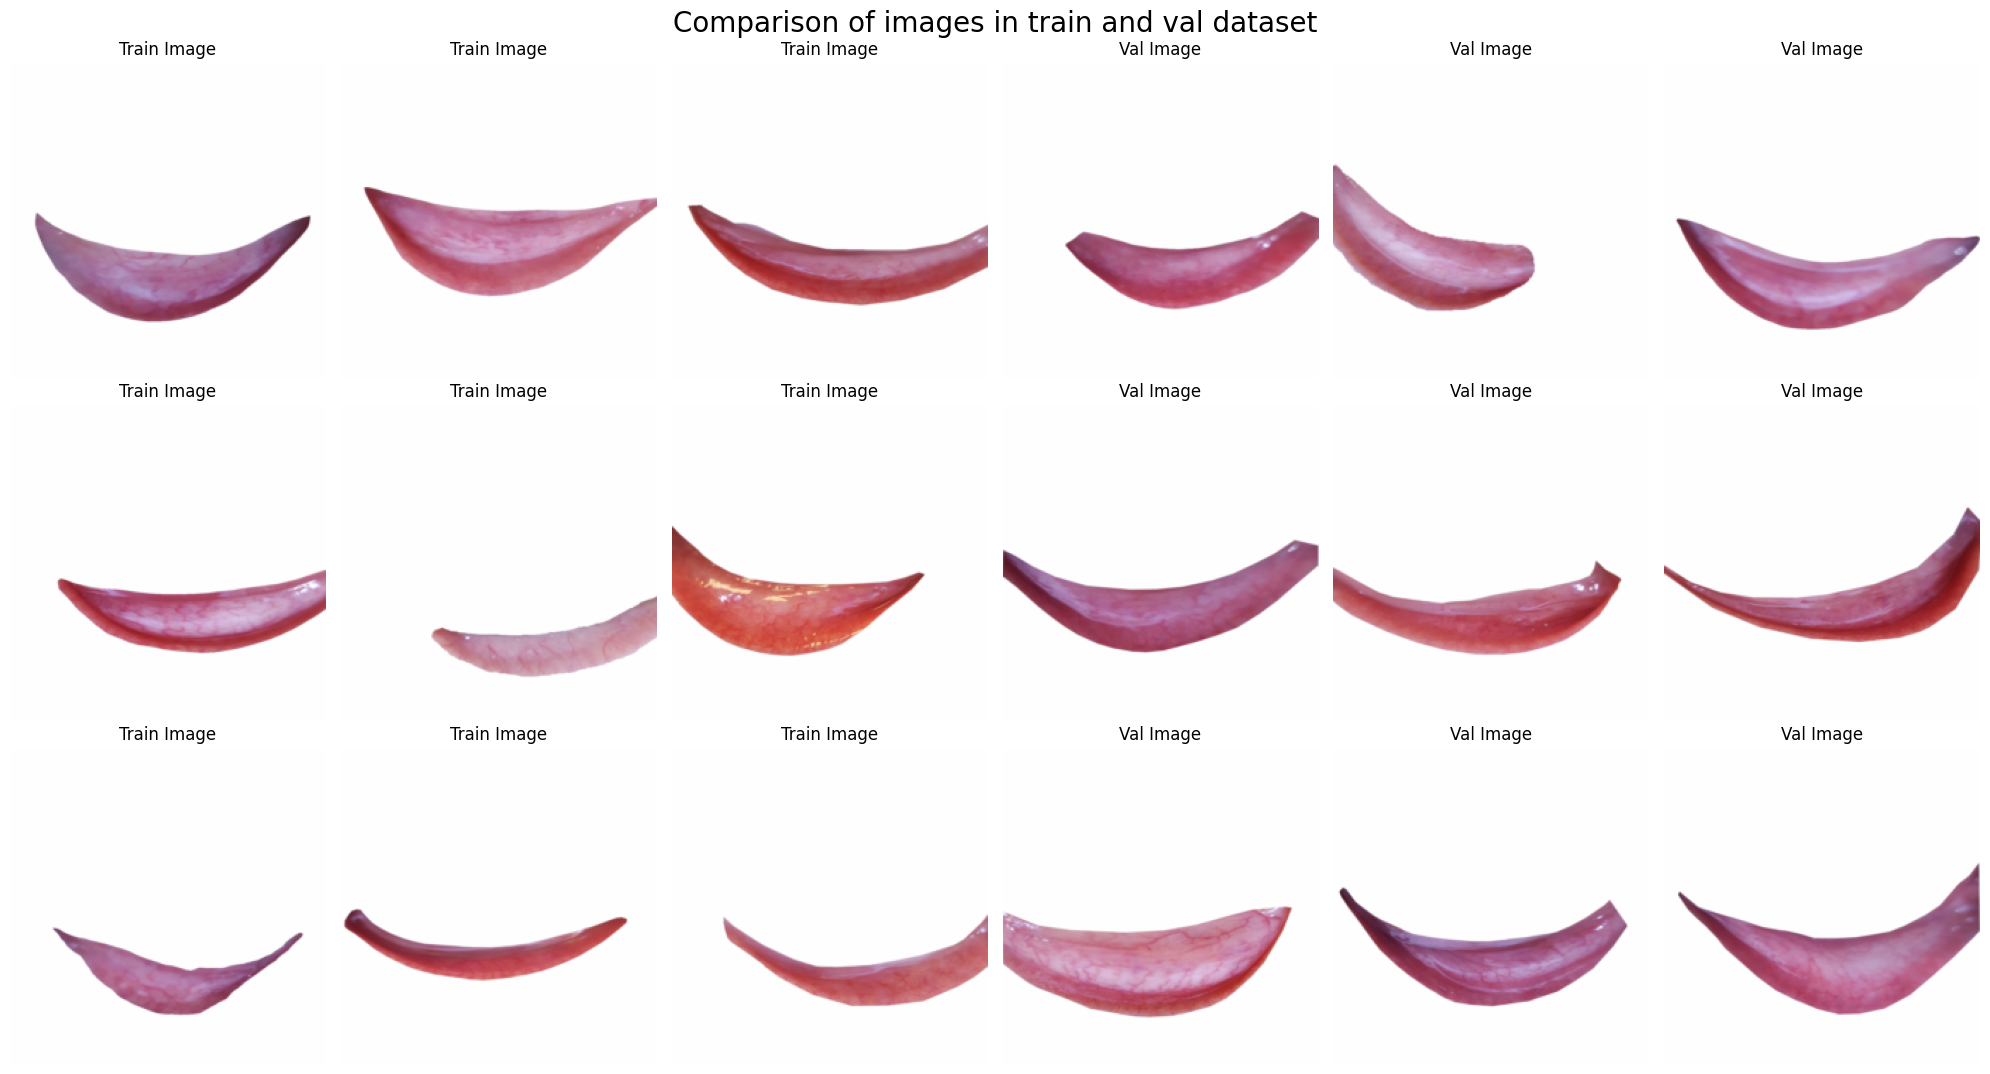

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, shear=0.2),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_val,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')

fig, axs = plt.subplots(3, 6, figsize=(20, 11))
fig.suptitle('Comparison of images in train and val dataset', fontsize=20)
for i in range(3):
    for j in range(3):
        n = np.random.randint(len(train_dataset))
        img = train_dataset[n][0].numpy().transpose((1, 2, 0))
        mean = np.array([0.4802, 0.4481, 0.3975])
        std = np.array([0.2302, 0.2265, 0.2262])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        axs[i, j].set_title('Train Image')
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

        m = np.random.randint(len(val_dataset))
        img = val_dataset[m][0].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        axs[i, j + 3].set_title('Val Image')
        axs[i, j + 3].imshow(img)
        axs[i, j + 3].axis('off')

plt.tight_layout()
plt.show()

In [15]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 125
Number of validation samples: 42


# Functions for training models

In [16]:
import copy
import torch
import numpy as np
from tqdm import tqdm

# Assuming `DEVICE` is defined (e.g., DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu"))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def training(model, model_name, num_epochs, train_dataloader, val_dataloader):
    loss_function = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):
        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:
            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE).float()  # Ensure targets are LongTensor

                        optimizer.zero_grad()
                        outputs = model(samples).squeeze(1)  # Squeeze the output to ensure it's of shape [batch_size]

                        loss = loss_function(outputs, targets)
                        preds = torch.round(torch.sigmoid(outputs))

                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE).float()  # Ensure targets are LongTensor

                        outputs = model(samples).squeeze(1)  # Squeeze the output to ensure it's of shape [batch_size]

                        loss = loss_function(outputs, targets)
                        preds = torch.round(torch.sigmoid(outputs))

                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array


In [17]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

# Training

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 15

### Training DenseNet161

c:\Users\Mayank Bhushan\Desktop\ANEMIA_Invasive\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mayank Bhushan\Desktop\ANEMIA_Invasive\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
125
42


  7%|▋         | 1/15 [00:03<00:45,  3.26s/it]

	| New lowest val loss for DenseNet161: 0.016379471336092268
Epoch: 2 | Learning rate: [0.0003]
125
42


 13%|█▎        | 2/15 [00:06<00:38,  2.97s/it]

	| New lowest val loss for DenseNet161: 0.0161282860097431
Epoch: 3 | Learning rate: [0.0003]
125
42


 20%|██        | 3/15 [00:08<00:33,  2.83s/it]

	| New lowest val loss for DenseNet161: 0.015933617239906675
Epoch: 4 | Learning rate: [9.9e-05]
125
42


 27%|██▋       | 4/15 [00:11<00:30,  2.75s/it]

	| New lowest val loss for DenseNet161: 0.0158789370741163
Epoch: 5 | Learning rate: [9.9e-05]
125
42


 33%|███▎      | 5/15 [00:14<00:27,  2.74s/it]

	| New lowest val loss for DenseNet161: 0.015829238153639295
Epoch: 6 | Learning rate: [9.9e-05]
125
42


 40%|████      | 6/15 [00:16<00:24,  2.71s/it]

	| New lowest val loss for DenseNet161: 0.015796823160988942
Epoch: 7 | Learning rate: [3.267e-05]
125


 47%|████▋     | 7/15 [00:19<00:21,  2.67s/it]

42
Epoch: 8 | Learning rate: [3.267e-05]
125


 53%|█████▎    | 8/15 [00:21<00:18,  2.62s/it]

42
Epoch: 9 | Learning rate: [3.267e-05]
125


 60%|██████    | 9/15 [00:24<00:15,  2.60s/it]

42
Epoch: 10 | Learning rate: [1.0781099999999999e-05]
125


 67%|██████▋   | 10/15 [00:26<00:12,  2.56s/it]

42
Epoch: 11 | Learning rate: [1.0781099999999999e-05]
125


 73%|███████▎  | 11/15 [00:29<00:10,  2.57s/it]

42
Epoch: 12 | Learning rate: [1.0781099999999999e-05]
125


 80%|████████  | 12/15 [00:31<00:07,  2.52s/it]

42
Epoch: 13 | Learning rate: [3.557763e-06]
125


 87%|████████▋ | 13/15 [00:34<00:05,  2.54s/it]

42
Epoch: 14 | Learning rate: [3.557763e-06]
125


 93%|█████████▎| 14/15 [00:36<00:02,  2.52s/it]

42
Epoch: 15 | Learning rate: [3.557763e-06]
125


100%|██████████| 15/15 [00:39<00:00,  2.63s/it]

42


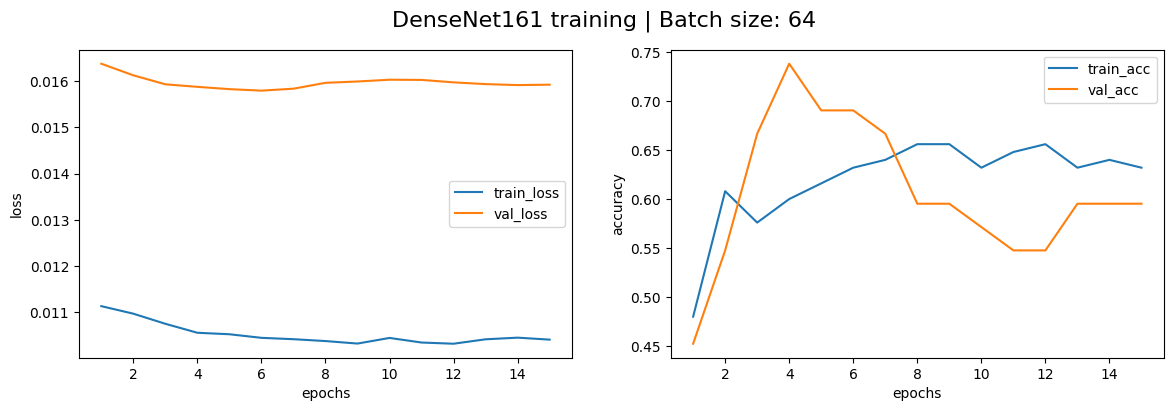


Training results:
	Min val loss 0.0158 was achieved during epoch #6
	Val accuracy during min val loss is 0.6905


In [19]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, 1)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Training ResNet152

c:\Users\Mayank Bhushan\Desktop\ANEMIA_Invasive\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mayank Bhushan\Desktop\ANEMIA_Invasive\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
125
42


  7%|▋         | 1/15 [00:03<00:42,  3.06s/it]

	| New lowest val loss for ResNet152: 0.017246618157341367
Epoch: 2 | Learning rate: [0.0003]
125
42


 13%|█▎        | 2/15 [00:05<00:37,  2.91s/it]

	| New lowest val loss for ResNet152: 0.01681757682845706
Epoch: 3 | Learning rate: [0.0003]
125
42


 20%|██        | 3/15 [00:08<00:34,  2.85s/it]

	| New lowest val loss for ResNet152: 0.016604339792614893
Epoch: 4 | Learning rate: [9.9e-05]
125
42


 27%|██▋       | 4/15 [00:11<00:30,  2.80s/it]

	| New lowest val loss for ResNet152: 0.016505484070096697
Epoch: 5 | Learning rate: [9.9e-05]
125
42


 33%|███▎      | 5/15 [00:14<00:27,  2.79s/it]

	| New lowest val loss for ResNet152: 0.016453392448879424
Epoch: 6 | Learning rate: [9.9e-05]
125
42


 40%|████      | 6/15 [00:16<00:24,  2.77s/it]

	| New lowest val loss for ResNet152: 0.0162799684774308
Epoch: 7 | Learning rate: [3.267e-05]
125


 47%|████▋     | 7/15 [00:19<00:21,  2.64s/it]

42
Epoch: 8 | Learning rate: [3.267e-05]
125


 53%|█████▎    | 8/15 [00:21<00:18,  2.57s/it]

42
Epoch: 9 | Learning rate: [3.267e-05]
125


 60%|██████    | 9/15 [00:24<00:15,  2.54s/it]

42
Epoch: 10 | Learning rate: [1.0781099999999999e-05]
125


 67%|██████▋   | 10/15 [00:26<00:12,  2.53s/it]

42
Epoch: 11 | Learning rate: [1.0781099999999999e-05]
125


 73%|███████▎  | 11/15 [00:29<00:10,  2.54s/it]

42
Epoch: 12 | Learning rate: [1.0781099999999999e-05]
125


 80%|████████  | 12/15 [00:31<00:07,  2.57s/it]

42
Epoch: 13 | Learning rate: [3.557763e-06]
125


 87%|████████▋ | 13/15 [00:34<00:05,  2.57s/it]

42
Epoch: 14 | Learning rate: [3.557763e-06]
125


 93%|█████████▎| 14/15 [00:37<00:02,  2.60s/it]

42
Epoch: 15 | Learning rate: [3.557763e-06]
125


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]

42


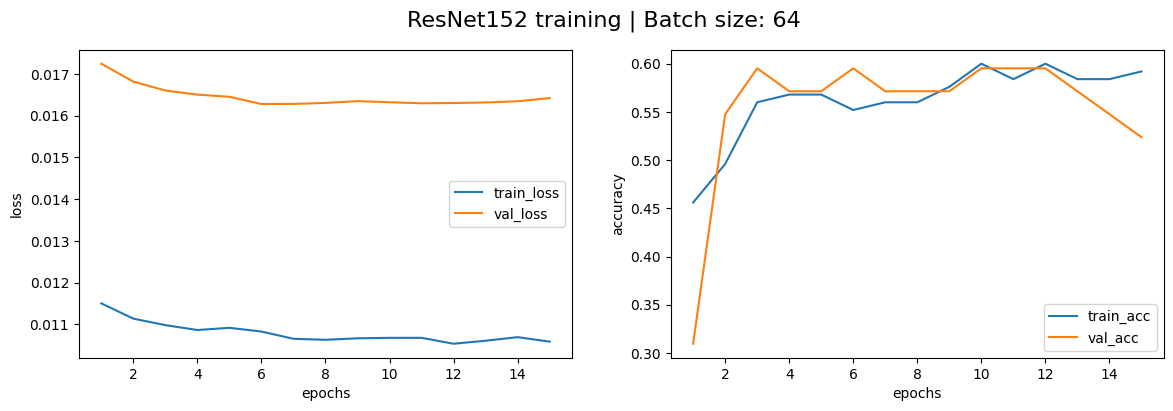


Training results:
	Min val loss 0.0163 was achieved during epoch #6
	Val accuracy during min val loss is 0.5952


In [20]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 1)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Training VGG19

c:\Users\Mayank Bhushan\Desktop\ANEMIA_Invasive\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mayank Bhushan\Desktop\ANEMIA_Invasive\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
125
42


  7%|▋         | 1/15 [00:03<00:55,  3.99s/it]

	| New lowest val loss for VGG19_bn: 0.01630972538675581
Epoch: 2 | Learning rate: [0.0003]
125
42


 13%|█▎        | 2/15 [00:07<00:51,  3.94s/it]

	| New lowest val loss for VGG19_bn: 0.016049834943953015
Epoch: 3 | Learning rate: [0.0003]
125
42


 20%|██        | 3/15 [00:17<01:15,  6.32s/it]

	| New lowest val loss for VGG19_bn: 0.01583950292496454
Epoch: 4 | Learning rate: [9.9e-05]
125
42


 27%|██▋       | 4/15 [00:20<00:58,  5.34s/it]

	| New lowest val loss for VGG19_bn: 0.015580293678102038
Epoch: 5 | Learning rate: [9.9e-05]
125
42


 33%|███▎      | 5/15 [00:29<01:05,  6.60s/it]

	| New lowest val loss for VGG19_bn: 0.015320059799012683
Epoch: 6 | Learning rate: [9.9e-05]
125
42


 40%|████      | 6/15 [00:33<00:51,  5.69s/it]

	| New lowest val loss for VGG19_bn: 0.015103838273457118
Epoch: 7 | Learning rate: [3.267e-05]
125
42


 47%|████▋     | 7/15 [00:42<00:53,  6.71s/it]

	| New lowest val loss for VGG19_bn: 0.015009438707714989
Epoch: 8 | Learning rate: [3.267e-05]
125
42


 53%|█████▎    | 8/15 [00:46<00:40,  5.82s/it]

	| New lowest val loss for VGG19_bn: 0.014945392097745622
Epoch: 9 | Learning rate: [3.267e-05]
125
42


 60%|██████    | 9/15 [00:55<00:40,  6.77s/it]

	| New lowest val loss for VGG19_bn: 0.014848341544469198
Epoch: 10 | Learning rate: [1.0781099999999999e-05]
125
42


 67%|██████▋   | 10/15 [00:59<00:29,  5.88s/it]

	| New lowest val loss for VGG19_bn: 0.014769050337019422
Epoch: 11 | Learning rate: [1.0781099999999999e-05]
125
42


 73%|███████▎  | 11/15 [01:07<00:27,  6.77s/it]

	| New lowest val loss for VGG19_bn: 0.01471052709079924
Epoch: 12 | Learning rate: [1.0781099999999999e-05]
125
42


 80%|████████  | 12/15 [01:11<00:17,  5.90s/it]

	| New lowest val loss for VGG19_bn: 0.014631265685671852
Epoch: 13 | Learning rate: [3.557763e-06]
125
42


 87%|████████▋ | 13/15 [01:20<00:13,  6.75s/it]

	| New lowest val loss for VGG19_bn: 0.01458489043372018
Epoch: 14 | Learning rate: [3.557763e-06]
125
42


 93%|█████████▎| 14/15 [01:24<00:05,  5.86s/it]

	| New lowest val loss for VGG19_bn: 0.014544420299075898
Epoch: 15 | Learning rate: [3.557763e-06]
125
42


100%|██████████| 15/15 [01:33<00:00,  6.21s/it]

	| New lowest val loss for VGG19_bn: 0.014489866438366118


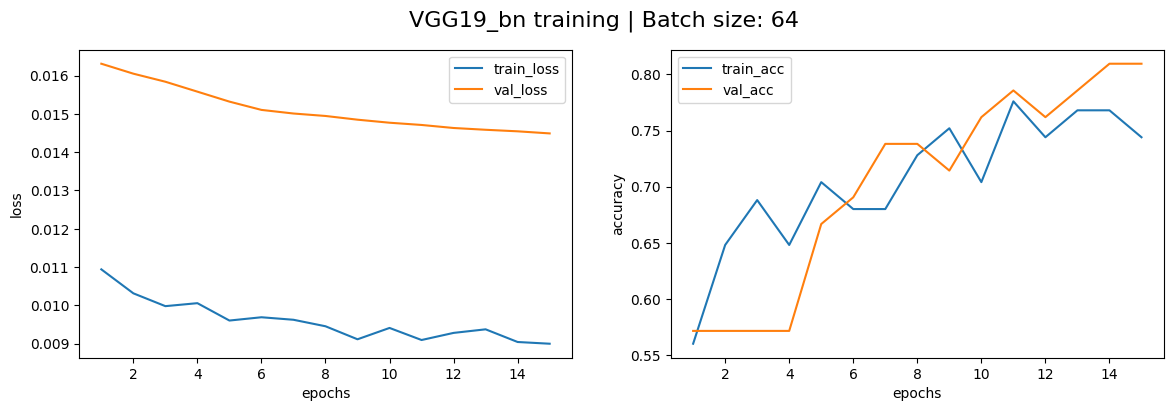


Training results:
	Min val loss 0.0145 was achieved during epoch #15
	Val accuracy during min val loss is 0.8095


In [24]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=1)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Training ensemble

In [27]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(200 * 3, 1)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

In [30]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=20,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=20,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  0%|          | 0/20 [00:01<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x135328 and 3000x1)

In [ ]:
import pandas as pd

# Load the CSV file
csv_path = 'AnemiC dataset/sheet1.csv'
df = pd.read_csv(csv_path)

# Verify there are no NaN values
print(df.isnull().sum())
print(df.head())


IMAGE_ID    0
HB_LEVEL    0
dtype: int64
    IMAGE_ID HB_LEVEL
0  Image_001        A
1  Image_002        A
2  Image_003        N
3  Image_004        N
4  Image_005        A


In [ ]:
import pandas as pd

# Load the CSV file
csv_path = 'AnemiC dataset/sheet1.csv'
df = pd.read_csv(csv_path)

# Display the unique values in the HB_LEVEL column to check for issues
print(df['HB_LEVEL'].unique())


['A' 'N']


In [ ]:
import pandas as pd
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score
import os

# Load the CSV file
csv_path = 'AnemiC dataset/sheet1.csv'
df = pd.read_csv(csv_path)

# Map HB_LEVEL to numerical labels
label_map = {'N': 0, 'A': 1}
df['label'] = df['HB_LEVEL'].map(label_map)

# Check for NaN values in the dataframe
print(df.isnull().sum())

# Drop rows with NaN values in the 'label' column
df = df.dropna(subset=['label'])

# Ensure the 'label' column is of integer type
df['label'] = df['label'].astype(int)

class AnemiCDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, extensions=('.jpg', '.jpeg', '.png')):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.extensions = extensions

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = None

        # Try finding the image with the provided extensions
        for ext in self.extensions:
            potential_path = os.path.join(self.root_dir, img_name + ext)
            if os.path.exists(potential_path):
                img_path = potential_path
                break

        if img_path is None:
            raise FileNotFoundError(f"Image {img_name} with any of the extensions {self.extensions} not found in {self.root_dir}")

        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transform for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size your model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset and dataloader
dataset_dir = 'AnemiC dataset'
predict_dataset = AnemiCDataset(dataframe=df, root_dir=dataset_dir, transform=transform)
predict_dataloader = DataLoader(predict_dataset, batch_size=32, shuffle=False)

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)

all_labels = []
all_preds = []

ensemble_model.eval()

with torch.no_grad():
    for data, labels in predict_dataloader:
        data, labels = data.to(device), labels.to(device)
        outputs = ensemble_model(data)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert collected labels and predictions to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Check for NaN values in labels and predictions
if np.isnan(all_labels).any() or np.isnan(all_preds).any():
    raise ValueError("Found NaN values in labels or predictions")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Compute F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score: {:.4f}".format(f1))


IMAGE_ID    0
HB_LEVEL    0
label       0
dtype: int64
Confusion Matrix:
 [[  0 411]
 [  0 299]]
F1 Score: 0.2496


In [ ]:
# Print some predictions to debug
for data, labels in predict_dataloader:
    data, labels = data.to(device), labels.to(device)
    outputs = ensemble_model(data)
    _, preds = torch.max(outputs, 1)
    print("True Labels:", labels)
    print("Predicted Labels:", preds)
    break


True Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0', dtype=torch.int32)
Predicted Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [ ]:
from sklearn.metrics import classification_report

# Print classification report for detailed metrics
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.42      1.00      0.59       299

    accuracy                           0.42       710
   macro avg       0.21      0.50      0.30       710
weighted avg       0.18      0.42      0.25       710



c:\Users\Mayank Bhushan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mayank Bhushan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mayank Bhushan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi